In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
#veriseti yolları
train_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\sonmodel\\dataset\\train"
test_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\sonmodel\\dataset\\test"
img_height, img_width = 512, 512
batch_size = 4


In [ ]:

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)


Found 6302 files belonging to 3 classes.


In [ ]:
#Validasyon veri seti
ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=1,
    seed=123,
    label_mode='categorical',
    shuffle=False
)

Found 1142 files belonging to 3 classes.


In [ ]:
class_names = ds_train.class_names
print("Class names:", class_names)

Class names: ['birads2', 'birads4', 'birads5']


In [ ]:
#Class Weight'si Hesaplama
class_counts = np.zeros(len(class_names))
for images, labels in ds_train:
    class_counts += np.sum(labels.numpy(), axis=0)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in ds_train])
)

class_weights = {i: class_weights[i] for i in range(len(class_names))}

#model birads4'ü bularken zorlandığı için ağırlığı 2.5 katına çıkarıldı.
class_weights[1] *= 2.5

print(f"Class weights: {class_weights}")

Class weights: {0: 1.9650763953850952, 1: 2.2404721274175197, 2: 0.7271258797738549}


In [ ]:
###############
#MODELİ OLUŞTUR
###############

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

#En son 2 layer unfreeze edildi.
for layer in base_model.layers[-2:]:
    layer.trainable = True

#Build new Sequential model
efficient_net = Sequential()
efficient_net.add(base_model)
efficient_net.add(GlobalAveragePooling2D())
efficient_net.add(Dense(128, activation='relu'))
efficient_net.add(Dropout(0.5))
efficient_net.add(Dense(3, activation='softmax'))

#Compile the model
efficient_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

efficient_net.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 16, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 4,213,926
Trainable params: 4,171,903
Non-trainable params: 42,023
_________________________________________

In [ ]:
################################
#F1 Score ve metricleri kaydetme
################################
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
#Define the F1 score callback
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.metrics = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.validation_data), axis=1)
        val_targ = np.concatenate([np.argmax(y, axis=1) for _, y in self.validation_data])

        precision = precision_score(val_targ, val_predict, average='weighted')
        recall = recall_score(val_targ, val_predict, average='weighted')
        f1 = f1_score(val_targ, val_predict, average='weighted')

        self.metrics.append({'epoch': epoch + 1, 'precision': precision, 'recall': recall, 'f1': f1})
        logs['val_precision'] = precision
        logs['val_recall'] = recall
        logs['val_f1'] = f1
        print(f" — val_precision: {precision}, val_recall: {recall}, val_f1: {f1}")

#Define the directory path for saving metrics.txt and model weights
output_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\sonmodel"

#Define the file path for saving the model weights
model_weights_path = os.path.join(output_dir, "model_weights_best_f1.h5")
#Define the file path for saving the metrics
metrics_file_path = os.path.join(output_dir, "metrics.txt")

class CustomModelCheckpoint(Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        val_f1 = logs.get('val_f1')
        if val_f1 is None:
            return

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.model.save_weights(self.file_path)
            print(f" — Saved model weights with val_f1: {val_f1:.4f} to {self.file_path}")

#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
metrics_callback = MetricsCallback(validation_data=ds_valid)
model_checkpoint = CustomModelCheckpoint(model_weights_path)

In [ ]:
#############
#Model eğitme
#############
epochs = 25
history = efficient_net.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_valid,
    class_weight=class_weights,
    callbacks=[reduce_lr, metrics_callback, model_checkpoint]
)
#metrikleri kaydetme
with open(metrics_file_path, 'w') as file:
    for metric in metrics_callback.metrics:
        file.write(f"Epoch: {metric['epoch']}, Precision: {metric['precision']}, Recall: {metric['recall']}, F1: {metric['f1']}\n")
efficient_net.save_weights(model_weights_path)

Epoch 1/25
1142/1142 [==============================] - 14s 11ms/step
 — val_precision: 0.622134713779416, val_recall: 0.47197898423817863, val_f1: 0.4262949652378751
 — Saved model weights with val_f1: 0.4263 to C:\Users\Ahmet Berkay\Desktop\sonmodel\model_weights_best_f1.h5
1576/1576 [==============================] - 241s 145ms/step - loss: 1.3299 - accuracy: 0.4427 - val_loss: 1.0262 - val_accuracy: 0.4720 - lr: 1.0000e-04 - val_precision: 0.6221 - val_recall: 0.4720 - val_f1: 0.4263
Epoch 2/25
1142/1142 [==============================] - 13s 11ms/step
 — val_precision: 0.6053890413498426, val_recall: 0.5201401050788091, val_f1: 0.49717643107521114
 — Saved model weights with val_f1: 0.4972 to C:\Users\Ahmet Berkay\Desktop\sonmodel\model_weights_best_f1.h5
1576/1576 [==============================] - 227s 144ms/step - loss: 1.1352 - accuracy: 0.5389 - val_loss: 0.9614 - val_accuracy: 0.5201 - lr: 1.0000e-04 - val_precision: 0.6054 - val_recall: 0.5201 - val_f1: 0.4972
Epoch 3/25
11

In [ ]:
# Sadece test seti üzerinde sınıf bazında metrikleri hesapla
def evaluate_model(model, test_data, class_names):
    test_predict = np.argmax(model.predict(test_data), axis=1)
    test_targ = np.concatenate([np.argmax(y, axis=1) for _, y in test_data])
    print(classification_report(test_targ, test_predict, digits=5))
    metrics = {}
    for i, class_name in enumerate(class_names):
        precision = precision_score(test_targ, test_predict, labels=[i], average='macro')
        recall = recall_score(test_targ, test_predict, labels=[i], average='macro')
        f1 = f1_score(test_targ, test_predict, labels=[i], average='macro')
        metrics[class_name] = {'precision': precision, 'recall': recall, 'f1': f1}
        print(f"Class: {class_name} — Precision: {precision}, Recall: {recall}, F1: {f1}")
    return metrics

# Modeli yükleyin ve test seti üzerinde değerlendirin
efficient_net.load_weights("C:\\Users\\Ahmet Berkay\\Desktop\\sonmodel\\model_weights_best_f1.h5")
test_metrics = evaluate_model(efficient_net, ds_valid, class_names)

#Metrikleri dosyaya kaydetme
metrics_file_path = os.path.join(output_dir, "class_metrics.txt")
with open(metrics_file_path, 'w') as file:
    for class_name, metrics in test_metrics.items():
        file.write(f"Class: {class_name}, Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1: {metrics['f1']}\n")

1142/1142 [==============================] - 24s 14ms/step
              precision    recall  f1-score   support

           0    0.51481   0.73936   0.60699       188
           1    0.51584   0.56576   0.53964       403
           2    0.69535   0.54265   0.60958       551

    accuracy                        0.58319      1142
   macro avg    0.57533   0.61592   0.58540      1142
weighted avg    0.60228   0.58319   0.58447      1142



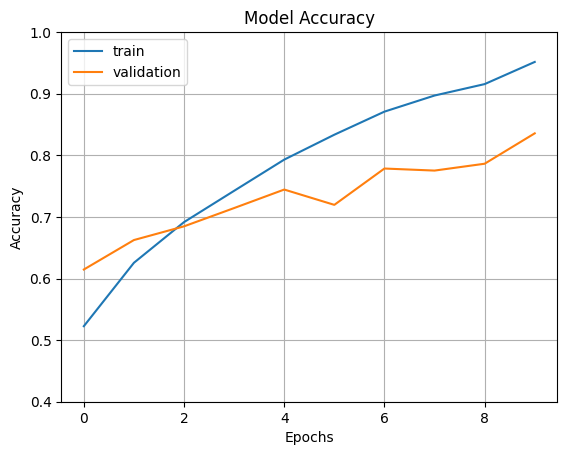

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

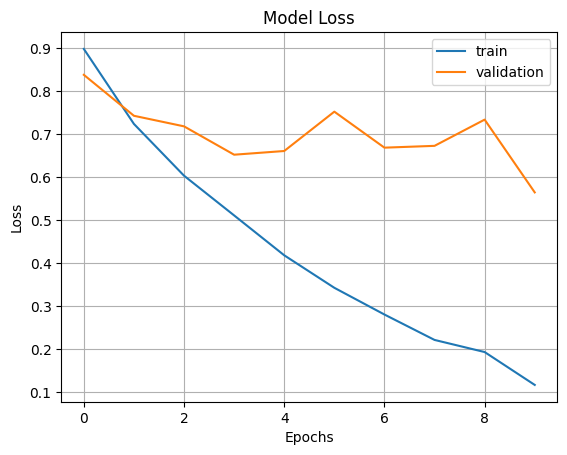

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

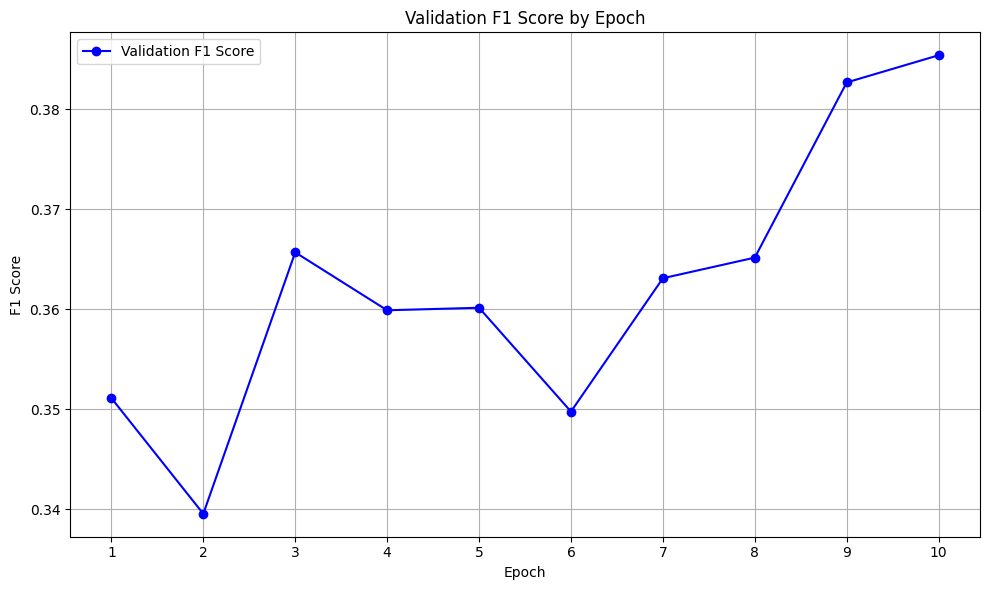

In [ ]:
epochs = range(1, len(metrics_callback.metrics) + 1)
f1_scores = [metric['f1'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='b', label='Validation F1 Score')
plt.title('Validation F1 Score by Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

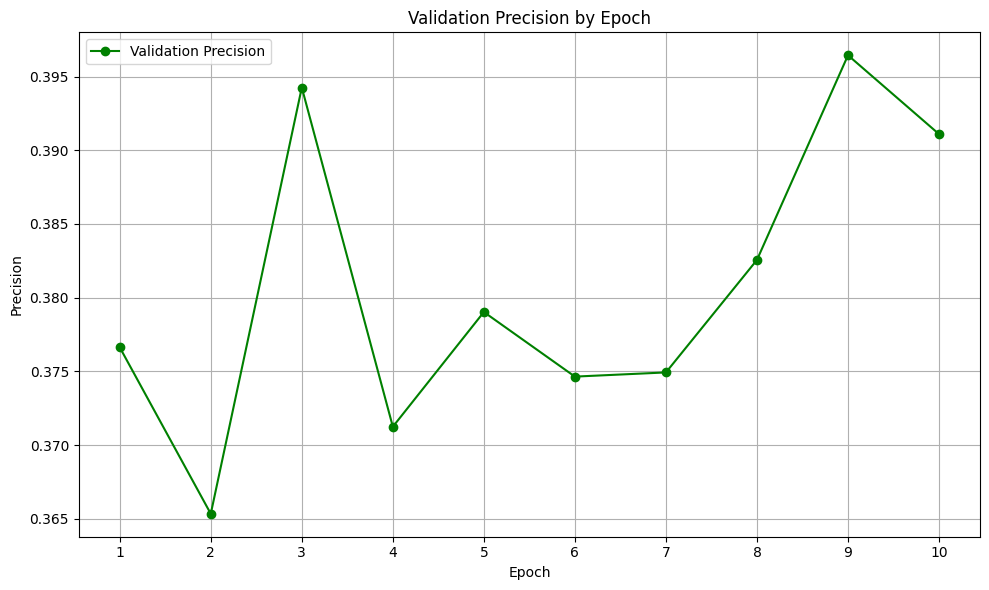

In [ ]:
epochs = range(1, len(metrics_callback.metrics) + 1)
precisions = [metric['precision'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, precisions, marker='o', linestyle='-', color='g', label='Validation Precision')
plt.title('Validation Precision by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

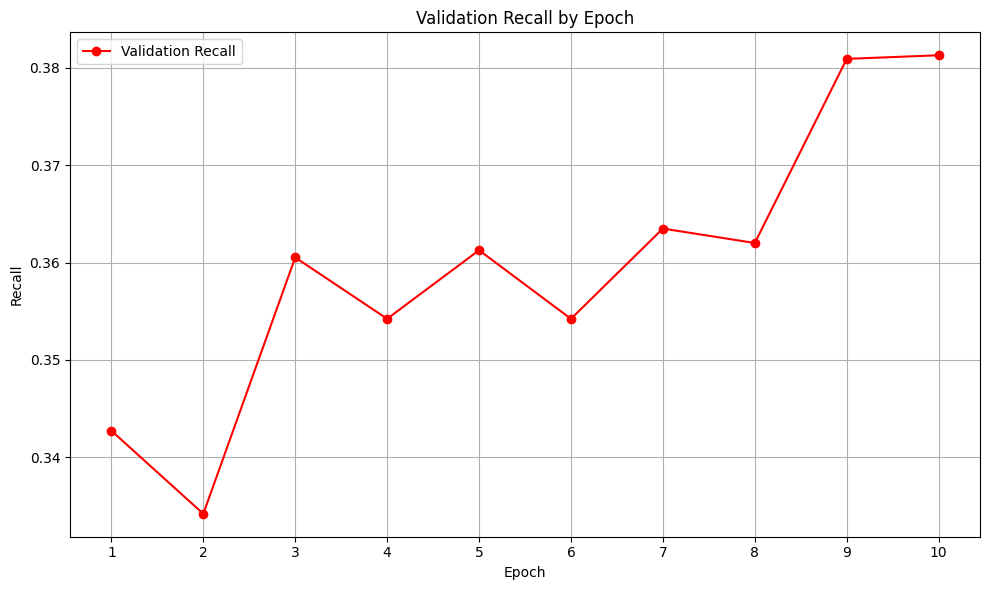

In [ ]:
epochs = range(1, len(metrics_callback.metrics) + 1)
recalls = [metric['recall'] for metric in metrics_callback.metrics]

plt.figure(figsize=(10, 6))
plt.plot(epochs, recalls, marker='o', linestyle='-', color='r', label='Validation Recall')
plt.title('Validation Recall by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
###################################################
#Object Detection Modelinden Gelen Resimleri Kırpma
###################################################
import os
import cv2

# Klasör yolları
images_folder = "C:\\Users\\Ahmet Berkay\\Desktop\\3yeniSet\\images"
labels_folder = "C:\\Users\\Ahmet Berkay\\Desktop\\yeniSet\\labels"
output_folder = "C:\\Users\\Ahmet Berkay\\Desktop\\yeniSet\\newimages"

# Kategori klasörlerini oluştur
categories = ['birads2', 'birads4', 'birads5']
for category in categories:
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)

# Her bir label dosyasını oku
for label_file in os.listdir(labels_folder):
    # Kategori1 olan dosyaları atla
    if 'Kategori1' in label_file:
        continue

    # İlgili resim dosyasını oku
    image_file = label_file.replace('.txt', '.png')
    image_path = os.path.join(images_folder, image_file)
    label_path = os.path.join(labels_folder, label_file)

    if not os.path.exists(image_path):
        print(f"Resim bulunamadı: {image_path}")
        continue

    # Resmi yükle
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(label_path, 'r') as file:
        labels = file.readlines()

    # Eğer label dosyası boşsa atla
    if not labels:
        continue

    # Her bir satır için kırpma işlemini gerçekleştir
    for idx, label in enumerate(labels):
        parts = label.strip().split()
        if len(parts) != 5:
            print(f"Label formatı yanlış: {label}")
            continue

        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

        # Koordinatları ve boyutları hesapla
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height

        # Kırpılacak alanı hesapla
        x1 = int(x_center - bbox_width - 100)
        y1 = int(y_center - bbox_height - 100)
        x2 = int(x_center + bbox_width + 100)
        y2 = int(y_center + bbox_height + 100)

        # Koordinatları sınırla
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Resmi kırp
        cropped_image = image[y1:y2, x1:x2]

        # Dosya ismi ve kategori belirleme
        category = None
        if 'Kategori2' in image_file:
            category = 'birads2'
        elif 'Kategori4' in image_file:
            category = 'birads4'
        elif 'Kategori5' in image_file:
            category = 'birads5'

        if category is not None:
            output_image_file = f"{os.path.splitext(image_file)[0]}_{idx}.png"
            output_image_path = os.path.join(output_folder, category, output_image_file)

            # Kırpılan resmi kaydet
            cv2.imwrite(output_image_path, cropped_image)

print("Kırpma işlemi tamamlandı.")

Kırpma işlemi tamamlandı.


In [ ]:
#############
#AUGMENTATİON
#############
import os
import glob
import numpy as np
from PIL import ImageEnhance, Image

# Veri ve hedef dizinleri tanımla
data_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\YOLO_format\\data\\new_pTrain2\\newTrain\\new_train"
augmented_dir = "C:\\Users\\Ahmet Berkay\\Desktop\\YOLO_format\\data\\new_pTrain2\\newTrain\\augmented_train_png"
img_height, img_width = 512, 512
class_names = ['birads2', 'birads4', 'birads5']

# Her sınıf için döngü oluştur
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    save_dir = os.path.join(augmented_dir, class_name)
    
    # Hedef klasörü oluştur
    os.makedirs(save_dir, exist_ok=True)
    
    # Sınıf klasöründeki resimleri al
    files = glob.glob(os.path.join(class_dir, '*.png'))
    
    # Resimleri oku ve artırma işlemlerini uygula
    for file in files:
        img = Image.open(file)
        img = img.resize((img_width, img_height))  # Gerekirse boyutlandırma yapılabilir
        
        # Orijinal resmi kaydet
        original_name = os.path.splitext(os.path.basename(file))[0] + '_original.png'
        save_path_original = os.path.join(save_dir, original_name)
        img.save(save_path_original)
        
        # 90, 180 ve 270 derece döndürme işlemleri
        rotations = [90, 180, 270]
        for rotation in rotations:
            rotated_img = img.rotate(rotation, expand=True)
            rotated_name = os.path.splitext(os.path.basename(file))[0] + f'_rotate{rotation}.png'
            save_path_rotated = os.path.join(save_dir, rotated_name)
            rotated_img.save(save_path_rotated)
        
        # Kontrast artırma işlemi
        enhancer = ImageEnhance.Contrast(img)
        enhanced_img = enhancer.enhance(1.5)  # Kontrastı 1.5 kat arttır
        enhanced_name = os.path.splitext(os.path.basename(file))[0] + '_enhanced.png'
        save_path_enhanced = os.path.join(save_dir, enhanced_name)
        enhanced_img.save(save_path_enhanced)

print("Veri artırma işlemi tamamlandı.")


Veri artırma işlemi tamamlandı.
